### Helper Functions

In [2]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import pandas as pd
from sklearn import preprocessing
from sklearn.datasets import load_digits

In [3]:
# returns 1 / n * Hessian of a matrix
def n_Hessian(A, eta):
  d = len(A[0,:]) # number of columns of A
  n = len(A) # number of rows of A
  return 1 / n * np.matmul(A.T, A) + eta * np.identity(d)

In [5]:
# stochastic gradient
def gradient(A, b, vec):
  n = len(A)
  d = len(A[0,:])
  one_hot = np.zeros((d, 1))
  one_hot[random.randint(0, d - 1)] = 1
  grad = 1 / n * np.expand_dims(np.squeeze(np.matmul((np.matmul(A, vec) - b).T, A)), axis=1) * one_hot
  return grad

In [6]:
# ground truth least squares optimal solution
def least_squares_min(A, b, eta):
  d = len(A[0,:])
  H = np.matmul(A.T, A) + eta * np.identity(d)
  return np.matmul(np.matmul(np.linalg.inv(H), A.T), b)

In [7]:
# vec is numpy array
def objective(vec, A, b):
  n = len(A)
  return 1 / n * sum((np.matmul(A, vec) - b)**2)

### Optimization Algorithms

In [8]:
# gradient descent
def gradient_descent(A, b, eta, l_rate, n_iter, x_0):
  d = len(A[0, :])
  H = n_Hessian(A, eta)
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)

  values = []
  values.append(x_0)

  for iter in range(1, n_iter):
    x = values[iter - 1] - l_rate * gradient(A, b, values[iter - 1])
    values.append(x)

  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return obj_sub

In [9]:
# NGD algorithm
def NGD(A, b, eta, n_iter, x_0):
  # initial value
  values = []
  values.append(x_0)

  for iter in range(1, n_iter):
    grad = gradient(A, b, values[iter - 1])
    grad_norm = np.sqrt(np.sum(grad**2))
    x = values[iter - 1] - 1 / math.sqrt(iter) * grad / grad_norm
    values.append(x)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return obj_sub

In [10]:
# Adagrad algorithm
def adagrad(A, b, eta, n_iter, x_0):
  # values
  values = []
  values.append(x_0)

  # gradients
  grad_norms_sq = []

  for iter in range(1, n_iter):
    grad = gradient(A, b, values[iter - 1])
    grad_norm_sq = np.sum(grad**2)
    grad_norms_sq.append(grad_norm_sq)
    x = values[iter - 1] - 1 / math.sqrt(np.sum(grad_norms_sq)) * grad
    values.append(x)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return obj_sub

In [11]:
# adam algorithm
def adam(A, b, eta, n_iter, alpha, beta_1, beta_2, eps, x_0):
  d = len(A[0,:])

  # initialize
  values = []
  values.append(x_0)
  m_list = []
  mv_0 = np.zeros((d, 1))
  m_list.append(mv_0)
  v_list = []
  v_list.append(mv_0)

  for iter in range(1, n_iter):
    grad = gradient(A, b, values[iter - 1])

    m = beta_1 * m_list[iter - 1] + (1 - beta_1) * grad
    m_list.append(m)
    v = beta_2 * v_list[iter - 1] + (1 - beta_2) * grad**2
    v_list.append(v)

    m_hat = m / (1 - beta_1**iter)
    v_hat = v / (1 - beta_2**iter)
    v_hat = np.array(v_hat).astype(float)
    x = values[iter - 1] - alpha * m_hat / (np.sqrt(v_hat) + eps)
    values.append(x)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return obj_sub

In [12]:
# marchenko-pastur acceleration
def marchenko_pastur(A, b, eta, n_iter, x_0):
  # parameters
  d = len(A[0,:])
  n = len(A)
  H = n_Hessian(A, eta)
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)

  # MP parameters
  r = d / n
  sigma_2 = 1
  rho = (1 + r) / np.sqrt(r)
  
  # update vector of deltas
  delta_0 = 0
  delta_1 = 1 / (-1 * rho - delta_0)
  delta = [delta_0, delta_1]

  x_1 = x_0 - 1 / ((1 + r) * sigma_2) * gradient(A, b, x_0)
  # update vector of values
  values = [x_0, x_1]

  # acceleration
  for iter in range(2, n_iter):
    # compute current delta
    delta_curr = 1 / (-1 * rho - delta[iter - 1])
    delta.append(delta_curr)
    # compute current value
    x_curr = values[iter - 1] + (1 + rho * delta[iter]) * (values[iter - 2] - values[iter - 1]) + delta[iter] * gradient(A, b, values[iter - 1]) / (sigma_2 * np.sqrt(r))
    values.append(x_curr)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return np.squeeze(obj_sub)

In [13]:
# simplified marchenko-pastur distribution
def marchenko_pastur_simp(A, b, eta, n_iter, x_0):
  # parameters
  d = len(A[0,:])
  n = len(A)
  H = n_Hessian(A, eta)
  r = d / n
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)
  sigma_2 = 1

  x_1 = x_0 - 1 / ((1 + r) * sigma_2) * gradient(A, b, x_0)
  # update vector of values
  values = [x_0, x_1]

  for iter in range(2, n_iter):
    # compute current value
    x_curr = values[iter - 1] - min(1 / r, r) * (values[iter - 2] - values[iter - 1]) - 1 / sigma_2 * min(1, 1 / r) * gradient(A, b, values[iter - 1])
    values.append(x_curr)

  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return np.squeeze(obj_sub)

In [14]:
# decaying exponential acceleration
def exponential(A, b, eta, n_iter, x_0):
  # hyperparameters
  d = len(A[0,:])
  H = n_Hessian(A, eta)
  lambda_0 = d / H.trace()
  eigval, eigvec = np.linalg.eigh(H)
  max_eig = max(eigval)

  # initial guess
  x_1 = x_0 - lambda_0 / 2 * gradient(A, b, x_0)
  values = [x_0, x_1]
  for iter in range(2, n_iter):
    x_curr = values[iter - 1] + (iter - 1) / (iter + 1) * (values[iter - 1] - values[iter - 2]) - lambda_0 / (iter + 1) * gradient(A, b, values[iter - 1])
    values.append(x_curr)

  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return np.squeeze(obj_sub)

In [15]:
# uniform acceleration
def uniform(A, b, eta, n_iter, x_0):
  # set up
  d = len(A[0,:])
  n = len(A)
  H = n_Hessian(A, eta)
  eigval, eigvec = np.linalg.eigh(H)
  L = max(eigval) # largest eigenvalue
  l = min(eigval) # minimum eigenvalue

  # initial guess
  x_1 = x_0

  values = [x_0, x_1]
  d_1 = -1 * (L + l) / 2
  d_list = [0, d_1]
  e_1 = -1 * (L - l)**2 / (4 * d_1 * (4 - 1))
  e_list = [0, e_1]
  m_1 = 1 / (d_1 - e_1)
  m_list = [0, m_1]

  for iter in range(2, n_iter):
    # compute d
    d_curr = -1 * (L + l) / 2 + e_list[iter - 1]
    d_list.append(d_curr)
    # compute e
    e_curr = -1 * (L - l)**2 * (iter**2) / (4 * d_curr * (4 * iter**2 - 1))
    e_list.append(e_curr)
    # compute m
    m_curr = 1 / (d_curr - e_curr + m_list[iter - 1] * d_curr * e_list[iter - 1])
    m_list.append(m_curr)

    # compute current value
    x_curr = values[iter - 1] + (1 - m_curr * (d_curr - e_curr)) * (values[iter - 2] - values[iter - 1]) + m_curr * gradient(A, b, values[iter - 1])
    values.append(x_curr)
  
  values = [np.squeeze(vec) for vec in values]
  b = np.squeeze(b)
  w = least_squares_min(A, b, eta)
  minimum = objective(w, A, b)
  obj_sub = np.array([objective(vec, A, b) - minimum for vec in values])
  return np.squeeze(obj_sub)

In [16]:
def optimization_stochastic(A, b, eta, n_iter, alpha, beta_1, beta_2, eps, x_0, disp, y_low, y_high):
  exp_obj = exponential(A, b, eta, n_iter, x_0)
  ngd_obj = NGD(A, b, eta, n_iter, x_0)
  adagrad_obj = adagrad(A, b, eta, n_iter, x_0)
  adam_obj = adam(A, b, eta, n_iter, alpha, beta_1, beta_2, eps, x_0)

  x = range(n_iter)

  if disp == 'one':
    plt.plot(x, exp_obj, color = 'purple', label = 'Exponential')
    plt.plot(x, ngd_obj, color = 'orange', label = "NGD")
    plt.plot(x, adagrad_obj, color = 'm', label = 'Adagrad')
    plt.plot(x, adam_obj, color = 'cyan', label = 'Adam')
    plt.title('Performance of Optimization Algorithms')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Suboptimality')
    plt.yscale('log')
    plt.legend()
    plt.show()
  
  if disp == 'many':
    plt.subplot(1, 4, 1)
    plt.plot(x, exp_obj)
    plt.title('Exponential')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([y_low, y_high])
    plt.yscale('log')

    plt.subplot(1, 4, 2)
    plt.plot(x, ngd_obj)
    plt.title('NGD')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([y_low, y_high])
    plt.yscale('log')

    plt.subplot(1, 4, 3)
    plt.plot(x, adagrad_obj)
    plt.title('Adagrad')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([y_low, y_high])
    plt.yscale('log')

    plt.subplot(1, 4, 4)
    plt.plot(x, adam_obj)
    plt.title('Adam')
    plt.xlabel('Iteration')
    plt.ylabel('Objective Suboptimality')
    plt.ylim([y_low, y_high])
    plt.yscale('log')

    plt.tight_layout()
    plt.show()

### Experiments with Synthetic Dataset

In [18]:
# second synthetic dataset
d = 900
n = 1000

A = np.random.normal(0.0, 1.0, size=(n, d)) # generate matrix
b = np.random.normal(0.0, 1.0, size=(n, 1)) # generate vector
H = n_Hessian(A, 0)

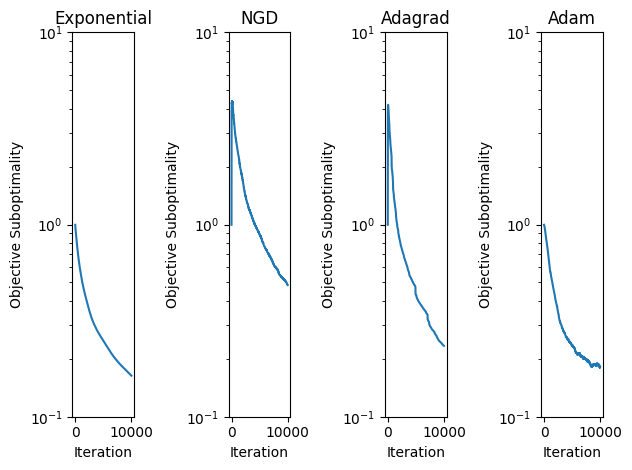

In [19]:
# plot all optimization algorithms
x_0 = np.random.random(size = (d, 1)) * 1e-3
optimization_stochastic(A, b, 0, 10000, 0.001, 0.9, 0.999, 1e-07, x_0, 'many', 1e-1, 10)